In [1]:
import json
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from scipy.spatial import procrustes
from numpy.linalg import norm

In [2]:
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

In [3]:
def cosine_similarity(data1, data2):
    landmarks1 = np.array(data1).flatten()
    landmarks2 = np.array(data2).flatten()
    similarity = np.dot(landmarks1, landmarks2) / (norm(landmarks1) * norm(landmarks2))
    return similarity

In [4]:
# RGB image를 display하는 함수
def show_rgb_image(img, title=None):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

## roll 값 이용 face alignment

In [5]:
def align_image_roll(image, bbox_data, target_roll, current_roll):
    # 이미지 로드
    img = image
    x, y, w, h = bbox_data
    # 이미지 중심 좌표 계산
    center = (x + w//2, y + h//2)

    # 회전해야 할 각도 계산
    rotation_degree = current_roll - target_roll #opencv는 각이 음수면 반시계 방향으로 회전해서 target_roll - current_roll이 아닌 current_roll - target_roll 해줘야함.

    # 회전 변환 행렬 생성
    M = cv2.getRotationMatrix2D(center, rotation_degree, 1.0)

    # 이미지 회전
    rotated_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    return rotated_img

In [ ]:
"""
img2 = cv2.imread('sim_demo/frame_00147.jpg')
img5 = cv2.imread('sim_demo/frame_00147_edit.jpg')

data2 = load_json('landmarks_data_demo/frame_00147.json')
data5 = load_json('landmarks_data_demo/frame_00147_edit.json')
roll2 = data2[0]['headpose'][2]
roll5 = data5[0]['headpose'][2]
bbox2 = data2[0]['bbox']
bbox5 = data5[0]['bbox']

show_rgb_image(align_image_roll(img5, bbox5, roll2, roll5))
show_rgb_image(img2)
"""

## 얼굴 크기 관련 통계

In [6]:
import os
import json

input_folder = 'output_frames'
features_folder = 'features_data'
subfolders = [f for f in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, f))]

headsize_lst = []

for subfolder in subfolders:
    features_subfolder_path = os.path.join(features_folder, subfolder)
    json_files = [f for f in os.listdir(features_subfolder_path) if f.endswith('json')]
    for file in json_files:
        json_file_path = os.path.join(features_subfolder_path, file)
        with open(json_file_path) as jsonfile:
            features_data = json.load(jsonfile)
            
        for data in features_data:
            x_min, y_min, x_max, y_max = data['bbox']
            head_size = (x_max - x_min) * (y_max - y_min)
            headsize_lst.append(head_size)


In [ ]:
print(len(headsize_lst))

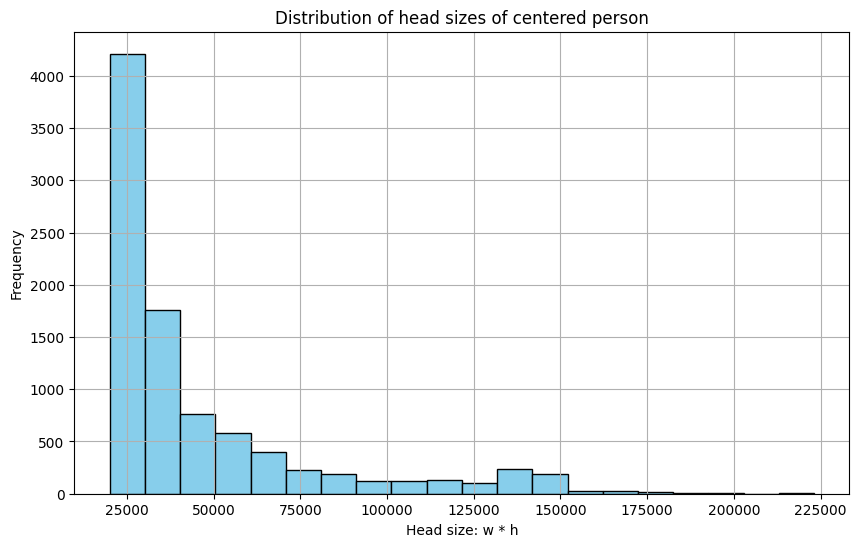

[ 21537.    23490.    25669.    28130.    31669.5   36450.    45214.4
  60446.4   72099.1   97205.8  135544.25 223155.  ]


In [7]:
headsize_arr = np.array(headsize_lst)
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 85, 90, 95, 100]
percentile_values = np.percentile(headsize_arr, percentiles)

plt.figure(figsize=(10, 6))
plt.hist(headsize_arr, bins = 20, color ='skyblue', edgecolor = 'black')
plt.title('Distribution of head sizes of centered person')
plt.xlabel('Head size: w * h')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(percentile_values)

## 유사한 얼굴 쌍 찾기

In [62]:
import itertools

input_folder = 'output_frames'
features_folder = 'features_data' #features의 경우 추출이 안되는 경우에는 추출하지 않았기 때문에 파일 갯수가 output_frames보다 적을 수 있음.
subfolders = [f for f in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, f))]

#features_folder의 각 subfolder들에 대해 동일한 파일명을 갖는 json파일을 이용해서 headpose에 대한 similarity를 계산, 최대 유사도를 갖는 pair를 찾음
#앞에서 계산한 통계를 바탕으로 중심인물의 얼굴이 특정 크기 이상인 경우에만 유사도 비교에 사용하기로 함.
# (프레임 번호, 최대 유사도를 갖는 파일 경로1, 최대 유사도를 갖는 파일 경로2)의 구조로 저장

frames_subfolder_path = os.path.join(input_folder, subfolders[0])
max_similarity = []
compare_list_file_name = []
compare_list_headpose = []
# frames_files에는 frame_00000.jpg , frame_00001.jpg ... 순서로 이미지 파일 이름이 있음
frame_files = [f for f in os.listdir(frames_subfolder_path) if f.endswith('jpg')]
for frame_file in frame_files:
    json_file = frame_file.replace('jpg', 'json')
    name_list = []
    headpose_list = []
    for subfolder in subfolders:
        json_file_path = os.path.join(features_folder, subfolder, json_file)
        if os.path.isfile(json_file_path) == True:
            with open(json_file_path) as jsonfile:
                features_data = json.load(jsonfile)
            for data in features_data:
                x_min, y_min, x_max, y_max = data['bbox']
                head_size = (x_max - x_min) * (y_max - y_min)
                if head_size > 20000: #여기서 얼굴 크기 지정해 줄 수 있음
                    name_list.append([json_file_path])
                    headpose_list.append(data['headpose'][0:3])
                    
    compare_list_file_name.append(name_list)
    compare_list_headpose.append(headpose_list)

for i in range(len(compare_list_file_name)):
    if len(compare_list_file_name[i]) > 1: #적어도 2개 이상이어야 유사도 계산이 가능
        max_sim = -2 #cosine_similarity의 최솟값은 -1
        max_indices = None
        for idx, pair in enumerate(itertools.combinations(enumerate(compare_list_headpose[i]), 2)):
            (idx1, headpose1), (idx2, headpose2) = pair
            similarity = cosine_similarity(headpose1, headpose2)
            if similarity > max_sim:
                max_sim = similarity
                max_indices = (idx1, idx2)
        max_similarity.append([compare_list_file_name[i][max_indices[0]][0], compare_list_file_name[i][max_indices[1]][0], max_sim])

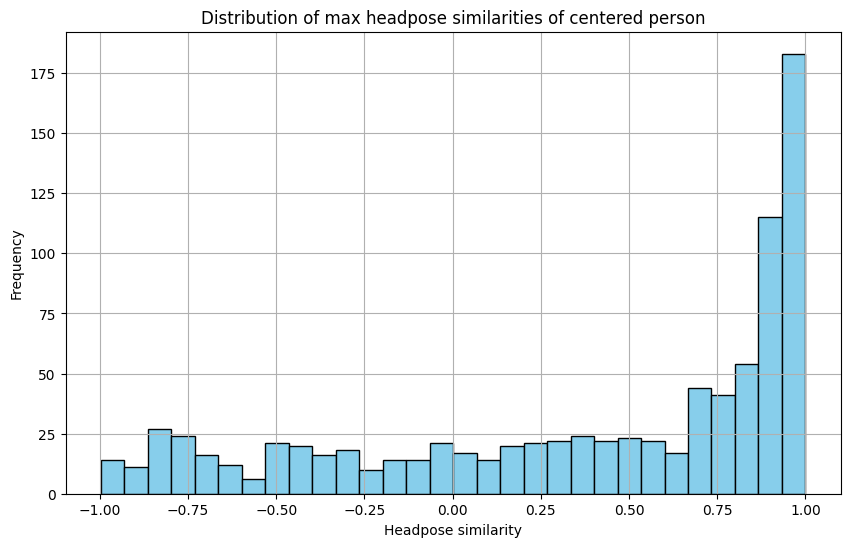

[-0.67869944 -0.29217809  0.08622813  0.3570344   0.65344342  0.79821747
  0.89305851  0.93478049  0.95489186  0.97759995  0.99300541  0.99988883]


In [44]:
max_sim_value = [item[2] for item in max_similarity]
max_similarity_arr = np.array(max_sim_value)
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 85, 90, 95, 100]
percentile_values = np.percentile(max_similarity_arr, percentiles)

plt.figure(figsize=(10, 6))
plt.hist(max_similarity_arr, bins = 30, color ='skyblue', edgecolor = 'black')
plt.title('Distribution of max headpose similarities of centered person')
plt.xlabel('Headpose similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(percentile_values)

In [63]:
max_sim_threshold = 0.98
max_sim_thresh_value = [item for item in max_similarity if item[2] > max_sim_threshold]

In [64]:
print(len(max_sim_thresh_value))

675


In [17]:
print(max_sim_thresh_value)

[['features_data\\1_frames\\frame_00301.json', 'features_data\\4_frames\\frame_00301.json', 0.9869754868996801], ['features_data\\1_frames\\frame_00302.json', 'features_data\\4_frames\\frame_00302.json', 0.9918576911903375], ['features_data\\1_frames\\frame_00303.json', 'features_data\\4_frames\\frame_00303.json', 0.9838917741245379], ['features_data\\1_frames\\frame_00304.json', 'features_data\\4_frames\\frame_00304.json', 0.9871008178869599], ['features_data\\1_frames\\frame_00322.json', 'features_data\\3_frames\\frame_00322.json', 0.9887494632835396], ['features_data\\3_frames\\frame_00327.json', 'features_data\\4_frames\\frame_00327.json', 0.9980321809852358], ['features_data\\3_frames\\frame_00328.json', 'features_data\\4_frames\\frame_00328.json', 0.9876479370685493], ['features_data\\3_frames\\frame_00329.json', 'features_data\\4_frames\\frame_00329.json', 0.9819097252718066], ['features_data\\3_frames\\frame_00330.json', 'features_data\\4_frames\\frame_00330.json', 0.9887406042

In [47]:
#기장 많은 조합에 대한 통계 분석
from collections import Counter

# 폴더명 추출 및 카운트
pair_counter = Counter()

for item in max_sim_thresh_value:
    frame1 = item[0].split('\\')[1]  # 첫 번째 파일의 폴더명 추출
    frame2 = item[1].split('\\')[1]  # 두 번째 파일의 폴더명 추출
    pair = tuple(sorted([frame1, frame2]))  # 정렬하여 순서에 상관없이 카운트
    pair_counter[pair] += 1

# 모든 페어와 그 횟수를 출력
print("모든 페어와 횟수:")
for pair, count in pair_counter.items():
    print(f"{pair}: {count}")

모든 페어와 횟수:
('1_frames', '4_frames'): 14
('1_frames', '3_frames'): 7
('3_frames', '4_frames'): 8
('2_frames', '5_frames'): 37
('1_frames', '2_frames'): 1
('4_frames', '5_frames'): 14
('3_frames', '5_frames'): 1


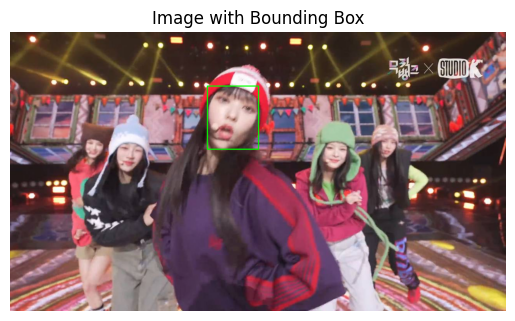

21516


In [19]:
img1= cv2.imread('output_frames/1_frames/frame_02899.jpg')
json_file_path = 'features_data/1_frames/frame_02899.json'
with open(json_file_path) as jsonfile:
    features_data = json.load(jsonfile)
    
# bounding box 좌표
for data in features_data:
    x1, y1, x2, y2 = data['bbox']

# 직사각형 그리기
cv2.rectangle(img1, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 2는 선의 두께

# 이미지 보여주기
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Image with Bounding Box')
plt.axis('off')
plt.show()

img1_cropped = img1[y1:y2, x1:x2]
print((x2-x1) * (y2-y1))

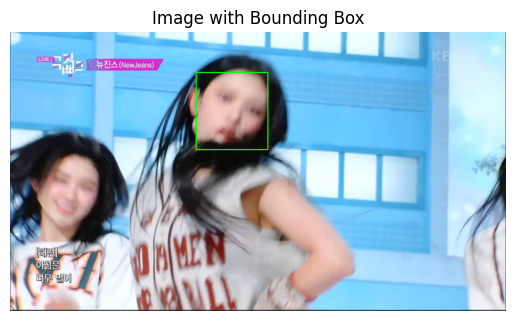

36815


In [20]:
img2 = cv2.imread('output_frames/5_frames/frame_02899.jpg')
json_file_path = 'features_data/5_frames/frame_02899.json'
with open(json_file_path) as jsonfile:
    features_data = json.load(jsonfile)
    
# bounding box 좌표
for data in features_data:
    x1, y1, x2, y2 = data['bbox']

# 직사각형 그리기
cv2.rectangle(img2, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 2는 선의 두께입니다.

# 이미지 보여주기
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Image with Bounding Box')
plt.axis('off')
plt.show()

img2_cropped = img2[y1:y2, x1:x2]
print((x2-x1) * (y2-y1))

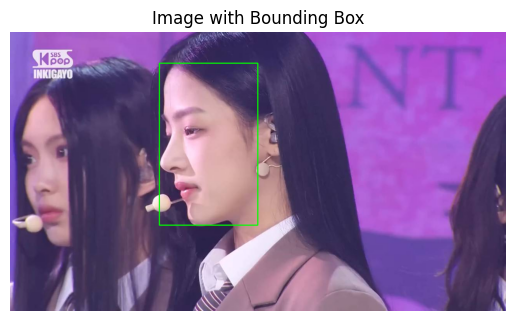

106172


In [21]:
img3 = cv2.imread('output_frames/3_frames/frame_00000.jpg')
json_file_path = 'features_data/3_frames/frame_00000.json'
with open(json_file_path) as jsonfile:
    features_data = json.load(jsonfile)
    
# bounding box 좌표
for data in features_data:
    x1, y1, x2, y2 = data['bbox']

# 직사각형 그리기
cv2.rectangle(img3, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 2는 선의 두께입니다.

# 이미지 보여주기
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.title('Image with Bounding Box')
plt.axis('off')
plt.show()

img3_cropped = img3[y1:y2, x1:x2]
print((x2-x1) * (y2-y1))

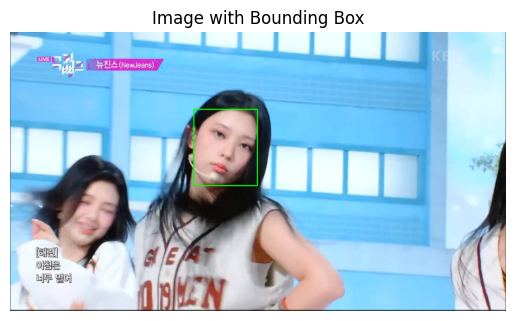

In [22]:
img4 = cv2.imread('output_frames/5_frames/frame_02902.jpg')
json_file_path = 'features_data/5_frames/frame_02902.json'
with open(json_file_path) as jsonfile:
    features_data = json.load(jsonfile)
    
# bounding box 좌표
for data in features_data:
    x1, y1, x2, y2 = data['bbox']
    
# 직사각형 그리기
cv2.rectangle(img4, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 2는 선의 두께입니다.

# 이미지 보여주기
plt.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
plt.title('Image with Bounding Box')
plt.axis('off')
plt.show()

img4_cropped = img3[y1:y2, x1:x2]

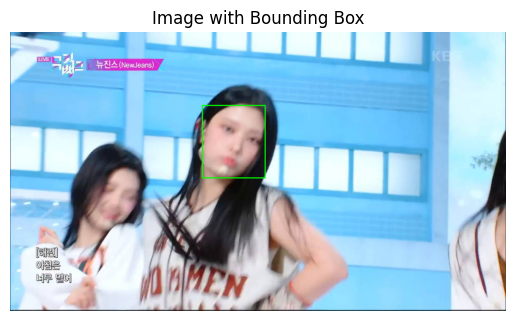

In [24]:
img5 = cv2.imread('output_frames/5_frames/frame_02904.jpg')
json_file_path = 'features_data/5_frames/frame_02904.json'
with open(json_file_path) as jsonfile:
    features_data = json.load(jsonfile)
    
# bounding box 좌표
for data in features_data:
    x1, y1, x2, y2 = data['bbox']

# 직사각형 그리기
cv2.rectangle(img5, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 2는 선의 두께입니다.

# 이미지 보여주기
plt.imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
plt.title('Image with Bounding Box')
plt.axis('off')
plt.show()

img5_cropped = img5[y1:y2, x1:x2]

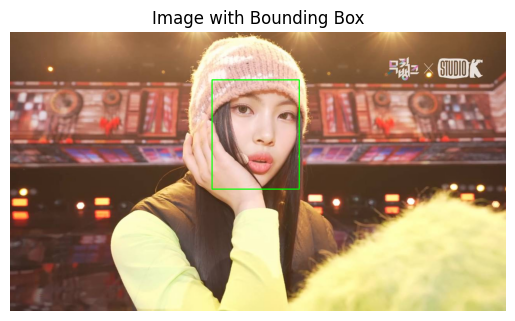

In [25]:
img6 = cv2.imread('output_frames/1_frames/frame_00301.jpg')
json_file_path = 'features_data/1_frames/frame_00301.json'
with open(json_file_path) as jsonfile:
    features_data = json.load(jsonfile)
    
# bounding box 좌표
for data in features_data:
    x1, y1, x2, y2 = data['bbox']

# 직사각형 그리기
cv2.rectangle(img6, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 2는 선의 두께입니다.

# 이미지 보여주기
plt.imshow(cv2.cvtColor(img6, cv2.COLOR_BGR2RGB))
plt.title('Image with Bounding Box')
plt.axis('off')
plt.show()

img6_cropped = img6[y1:y2, x1:x2]

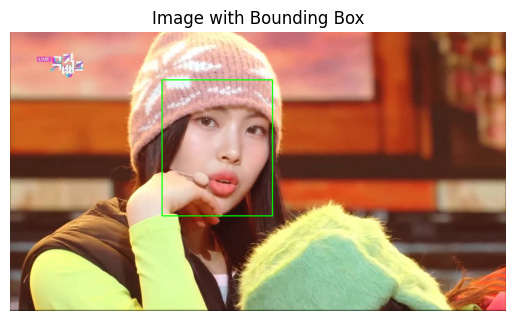

In [67]:
img7 = cv2.imread('output_frames/4_frames/frame_00301.jpg')
json_file_path = 'features_data/4_frames/frame_00301.json'
with open(json_file_path) as jsonfile:
    features_data = json.load(jsonfile)
    
# bounding box 좌표
for data in features_data:
    x1, y1, x2, y2 = data['bbox']

# 직사각형 그리기
cv2.rectangle(img7, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 2는 선의 두께입니다.

# 이미지 보여주기
plt.imshow(cv2.cvtColor(img7, cv2.COLOR_BGR2RGB))
plt.title('Image with Bounding Box')
plt.axis('off')
plt.show()

img7_cropped = img7[y1:y2, x1:x2]

## headpose 유사도가 높게 나온 얼굴에 대해 face verification 진행

In [36]:
from deepface import DeepFace

def face_verification(img1, img2):
    result = DeepFace.verify(img1, img2, model_name='Facenet', enforce_detection=False)
    return result['verified']
    
# FaceNet 모델을 사용하여 두 이미지 비교
result1 = face_verification(img1_cropped, img2_cropped)
result2 = face_verification(img2_cropped, img6_cropped)

# 결과 출력
print("Are the two faces of the same person?:", result1)
print("Are the two faces of the same person?:", result2)

Are the two faces of the same person?: True
Are the two faces of the same person?: False


## 얼굴이 흐리지 않고 명확하게 나온 경우에 대해서 유사하다고 판단? 

참조: https://pypi.org/project/brisque/
개인적으로는 brisque threshold를 55정도로 두면 좋을 듯?

In [65]:
import os
import json
import cv2
from brisque import BRISQUE

def load_image_and_crop(json_filepath, img_folder):
    # JSON 파일에서 Bounding Box 정보를 로드하고 이미지를 크롭
    with open(json_filepath, 'r') as file:
        features_data = json.load(file)
    x1, y1, x2, y2 = features_data[0]['bbox']  # 가정: 유효한 bbox가 항상 존재
    img_path = json_filepath.replace('json', 'jpg').replace('features_data', img_folder)
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found at {img_path}")
    if x1 < 0 or y1 < 0 or x2 > img.shape[1] or y2 > img.shape[0]:
        raise ValueError(f"Invalid bbox {x1, y1, x2, y2} for image dimensions {img.shape}")
    cropped_img = img[y1:y2, x1:x2]
    return cropped_img, img_path

input_folder = 'output_frames'
features_folder = 'features_data'

# BRISQUE 객체 생성
obj = BRISQUE(url=False)

# max_sim_thresh_value 리스트 내의 각 아이템 처리
num = 0
for item in max_sim_thresh_value:
    try:
        img1_cropped, frame1 = load_image_and_crop(item[0], input_folder)
        img2_cropped, frame2 = load_image_and_crop(item[1], input_folder)
        # BRISQUE 점수 계산
        score1 = obj.score(img1_cropped)
        score2 = obj.score(img2_cropped)
        # 결과 출력
        if score1 < 40 and score2 < 40:
            if face_verification(img1_cropped, img2_cropped) == True:
                num += 1
                print(f"BRISQUE Score: {frame1, score1},{frame2, score2}")
    except Exception as e:
        print(str(e))

print(num)

BRISQUE Score: ('output_frames\\1_frames\\frame_00301.jpg', 17.524237486714554),('output_frames\\4_frames\\frame_00301.jpg', 35.186298022839054)
BRISQUE Score: ('output_frames\\1_frames\\frame_00302.jpg', 18.424563952107718),('output_frames\\4_frames\\frame_00302.jpg', 34.86648603324463)
BRISQUE Score: ('output_frames\\1_frames\\frame_00303.jpg', 16.429775854438475),('output_frames\\4_frames\\frame_00303.jpg', 34.898676027826895)
BRISQUE Score: ('output_frames\\1_frames\\frame_00304.jpg', 18.600135087134817),('output_frames\\4_frames\\frame_00304.jpg', 33.09071929379908)
BRISQUE Score: ('output_frames\\1_frames\\frame_00734.jpg', 18.427126047464952),('output_frames\\4_frames\\frame_00734.jpg', 30.541017899421234)
BRISQUE Score: ('output_frames\\1_frames\\frame_00752.jpg', 37.749568310598846),('output_frames\\5_frames\\frame_00752.jpg', 33.343960271538634)
BRISQUE Score: ('output_frames\\1_frames\\frame_00764.jpg', 34.95490338548424),('output_frames\\4_frames\\frame_00764.jpg', 38.69631